In [ ]:
from re import I
# Cell 1 — Imports & Config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ARCHIVE_ROOT = '/content/drive/MyDrive/Colab Notebooks/archive (1)'
METADATA_CSV = '/content/drive/MyDrive/Colab Notebooks/archive (1)/cards.csv'
IMG_BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/archive (1)/'

IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
EPOCHS      = 10
NUM_CLASSES = 14
SEED        = 42


In [ ]:
# Cell 2 — Load & prep metadata
df = pd.read_csv(METADATA_CSV)

train_df = df[df['data set']=='train'].copy().reset_index(drop=True)

train_df['card type'] = pd.Categorical(train_df['card type'])

label_names = train_df['card type'].cat.categories.tolist()

y_labels = train_df['card type'].cat.codes.values

print("Found classes:", label_names)
print("Numeric labels example:", y_labels[:10])


Found classes: ['ace', 'eight', 'five', 'four', 'jack', 'king', 'nine', 'queen', 'seven', 'six', 'ten', 'three', 'two', 'xxx']
Numeric labels example: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Cell 3: Model factory (EfficientNetB0 for A100) ---
from tensorflow.keras.applications import EfficientNetB0

def build_model(method='bottleneck'):
    base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))

    if method == 'bottleneck':
        base.trainable = False
    elif method == 'finetune':
        for layer in base.layers:
            layer.trainable = layer.name.startswith('block7')
    else:
        raise ValueError

    inp = layers.Input(IMG_SIZE+(3,))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# --- Cell 3: Model factory (MobileNetV2 version) ---
from tensorflow.keras.applications import MobileNetV2

def build_model(method='bottleneck'):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))

    if method == 'bottleneck':
        base.trainable = False
    elif method == 'finetune':
        for layer in base.layers:
            layer.trainable = layer.name.startswith('block_16')
    else:
        raise ValueError

    inp = layers.Input(IMG_SIZE+(3,))
    x = base(inp, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# --- Cell 4: Data‑generator helper ---
def make_generator(df_subset, augment=False):
    if augment:
        aug = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True
        )
    else:
        aug = ImageDataGenerator(rescale=1./255)
    return aug.flow_from_dataframe(
        dataframe  = df_subset,
        directory  = ARCHIVE_ROOT,
        x_col      = 'filepaths',
        y_col      = 'card type',
        target_size= IMG_SIZE,
        class_mode = 'categorical',
        batch_size = BATCH_SIZE,
        shuffle    = True,
        seed       = SEED
    )


In [ ]:
# tf.data pipeline generator ---
def make_tf_dataset(df_subset):
    paths = df_subset['filepaths'].apply(lambda p: os.path.join(ARCHIVE_ROOT, p)).values
    labels = tf.keras.utils.to_categorical(df_subset['card type'].cat.codes.values, NUM_CLASSES)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load_and_process(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label

    ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(_load_and_process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds


In [ ]:
# --- Cell 5: 5‑Fold training loop (tf.data + MobileNetV2) ---
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
val_accs = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df, y_labels), start=1):
    print(f"\n--- Fold {fold} ---")
    df_tr = train_df.iloc[tr_idx]
    df_va = train_df.iloc[va_idx]

    train_ds = make_tf_dataset(df_tr)
    val_ds   = make_tf_dataset(df_va)

    model = build_model(method='bottleneck')
    history = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        verbose=2)

    best_val = max(history.history['val_accuracy'])
    val_accs.append(best_val)
    print(f"Fold {fold} best val_acc: {best_val:.4f}")

print(f"\n▶ Mean val_acc: {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")



--- Fold 1 ---
Epoch 1/10
191/191 - 134s - 700ms/step - accuracy: 0.2587 - loss: 2.2143 - val_accuracy: 0.3725 - val_loss: 1.8636
Epoch 2/10
191/191 - 9s - 46ms/step - accuracy: 0.4368 - loss: 1.6910 - val_accuracy: 0.4689 - val_loss: 1.6307
Epoch 3/10
191/191 - 8s - 44ms/step - accuracy: 0.5239 - loss: 1.4734 - val_accuracy: 0.4970 - val_loss: 1.5149
Epoch 4/10
191/191 - 9s - 45ms/step - accuracy: 0.5811 - loss: 1.3302 - val_accuracy: 0.5292 - val_loss: 1.4370
Epoch 5/10
191/191 - 9s - 45ms/step - accuracy: 0.6206 - loss: 1.2267 - val_accuracy: 0.5574 - val_loss: 1.3815
Epoch 6/10
191/191 - 9s - 45ms/step - accuracy: 0.6468 - loss: 1.1453 - val_accuracy: 0.5725 - val_loss: 1.3381
Epoch 7/10
191/191 - 9s - 45ms/step - accuracy: 0.6762 - loss: 1.0696 - val_accuracy: 0.5902 - val_loss: 1.3052
Epoch 8/10
191/191 - 8s - 44ms/step - accuracy: 0.6963 - loss: 1.0086 - val_accuracy: 0.5921 - val_loss: 1.2798
Epoch 9/10
191/191 - 9s - 45ms/step - accuracy: 0.7160 - loss: 0.9536 - val_accuracy:

In [ ]:
# Data Cleaning
from os.path import exists, join

train_df['abs_path'] = train_df['filepaths'].apply(lambda p: join(ARCHIVE_ROOT, p))

exists_mask = train_df['abs_path'].apply(exists)
missing = train_df.loc[~exists_mask]
print("Missing files:\n", missing['abs_path'].tolist())

train_df = train_df[exists_mask].reset_index(drop=True)
y_labels = train_df['card type'].cat.codes.values


Missing files:
 ['/content/drive/MyDrive/Colab Notebooks/archive (1)/train/ace of clubs/output']


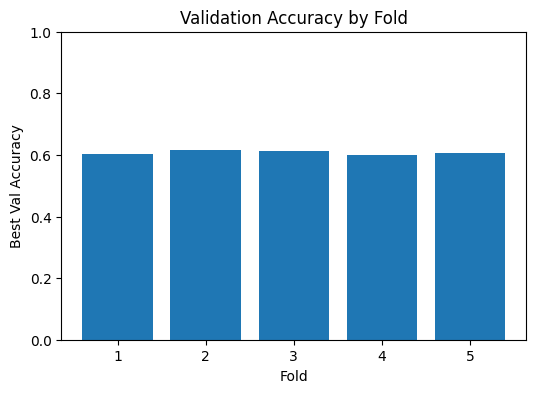

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(range(1,6), val_accs)
plt.xlabel('Fold')
plt.ylabel('Best Val Accuracy')
plt.ylim(0,1)
plt.title('Validation Accuracy by Fold')
plt.show()

In [ ]:
def show_feature_maps(model, img_path, layer_name='block3_conv1', n_maps=16):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    x   = tf.keras.preprocessing.image.img_to_array(img)[None,...] / 255.0

    intermediate = models.Model(
        inputs=model.input,
        outputs=model.get_layer(layer_name).output
    )
    feats = intermediate.predict(x)[0]

    # plot first n_maps
    n_cols = int(np.sqrt(n_maps))
    fig, axs = plt.subplots(n_cols, n_cols, figsize=(n_cols*2,n_cols*2))
    for i, ax in enumerate(axs.flat):
        ax.imshow(feats[..., i], cmap='viridis')
        ax.axis('off')
    plt.suptitle(f"{layer_name} activations for\n{img_path.split('/')[-2]} → {img_path.split('/')[-1]}")
    plt.show()


=== test/king of hearts/1.jpg @ layer block_3_expand_relu ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


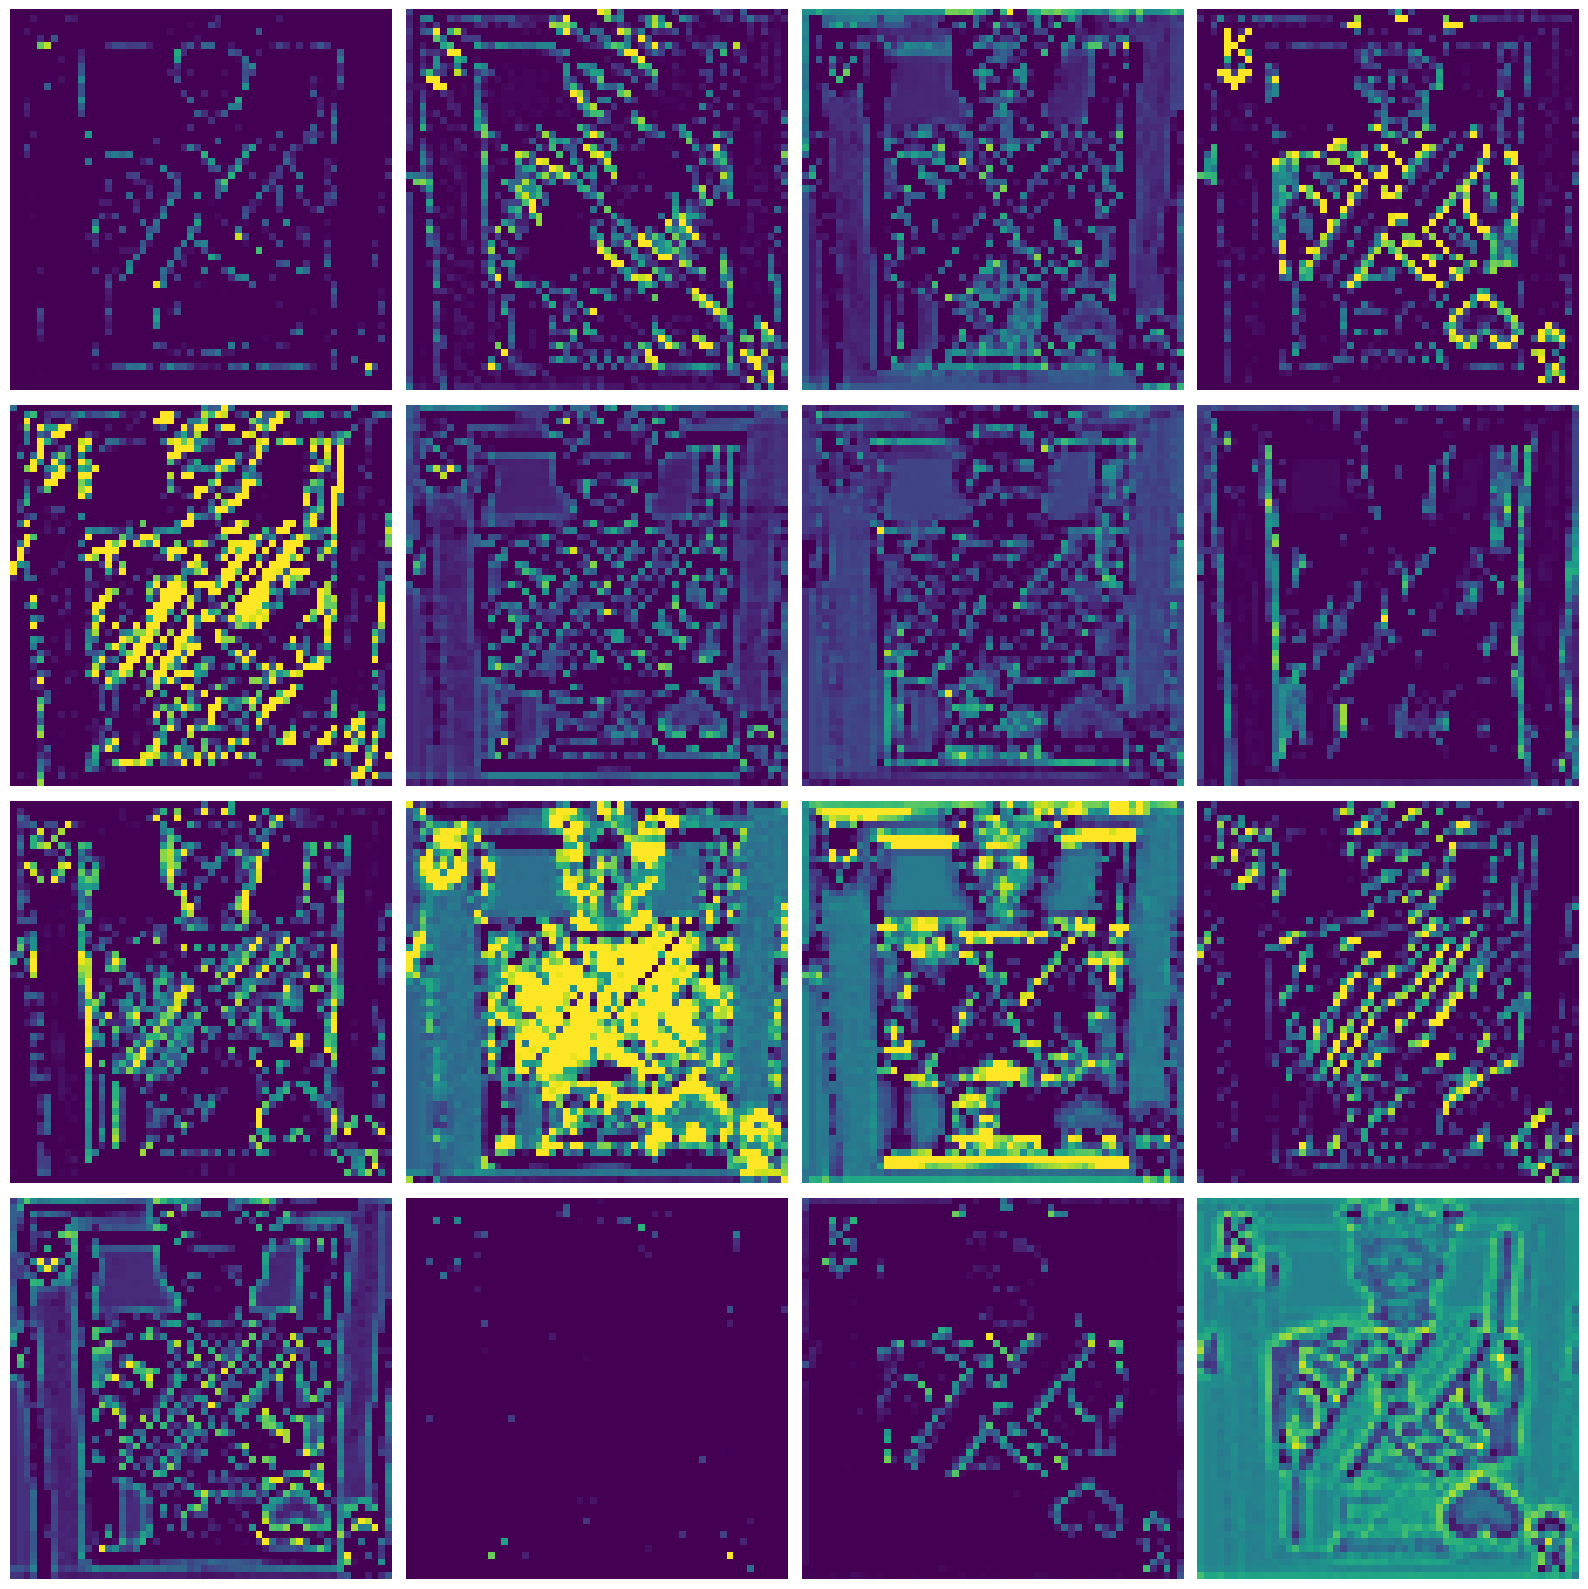


=== test/queen of spades/1.jpg @ layer block_3_expand_relu ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


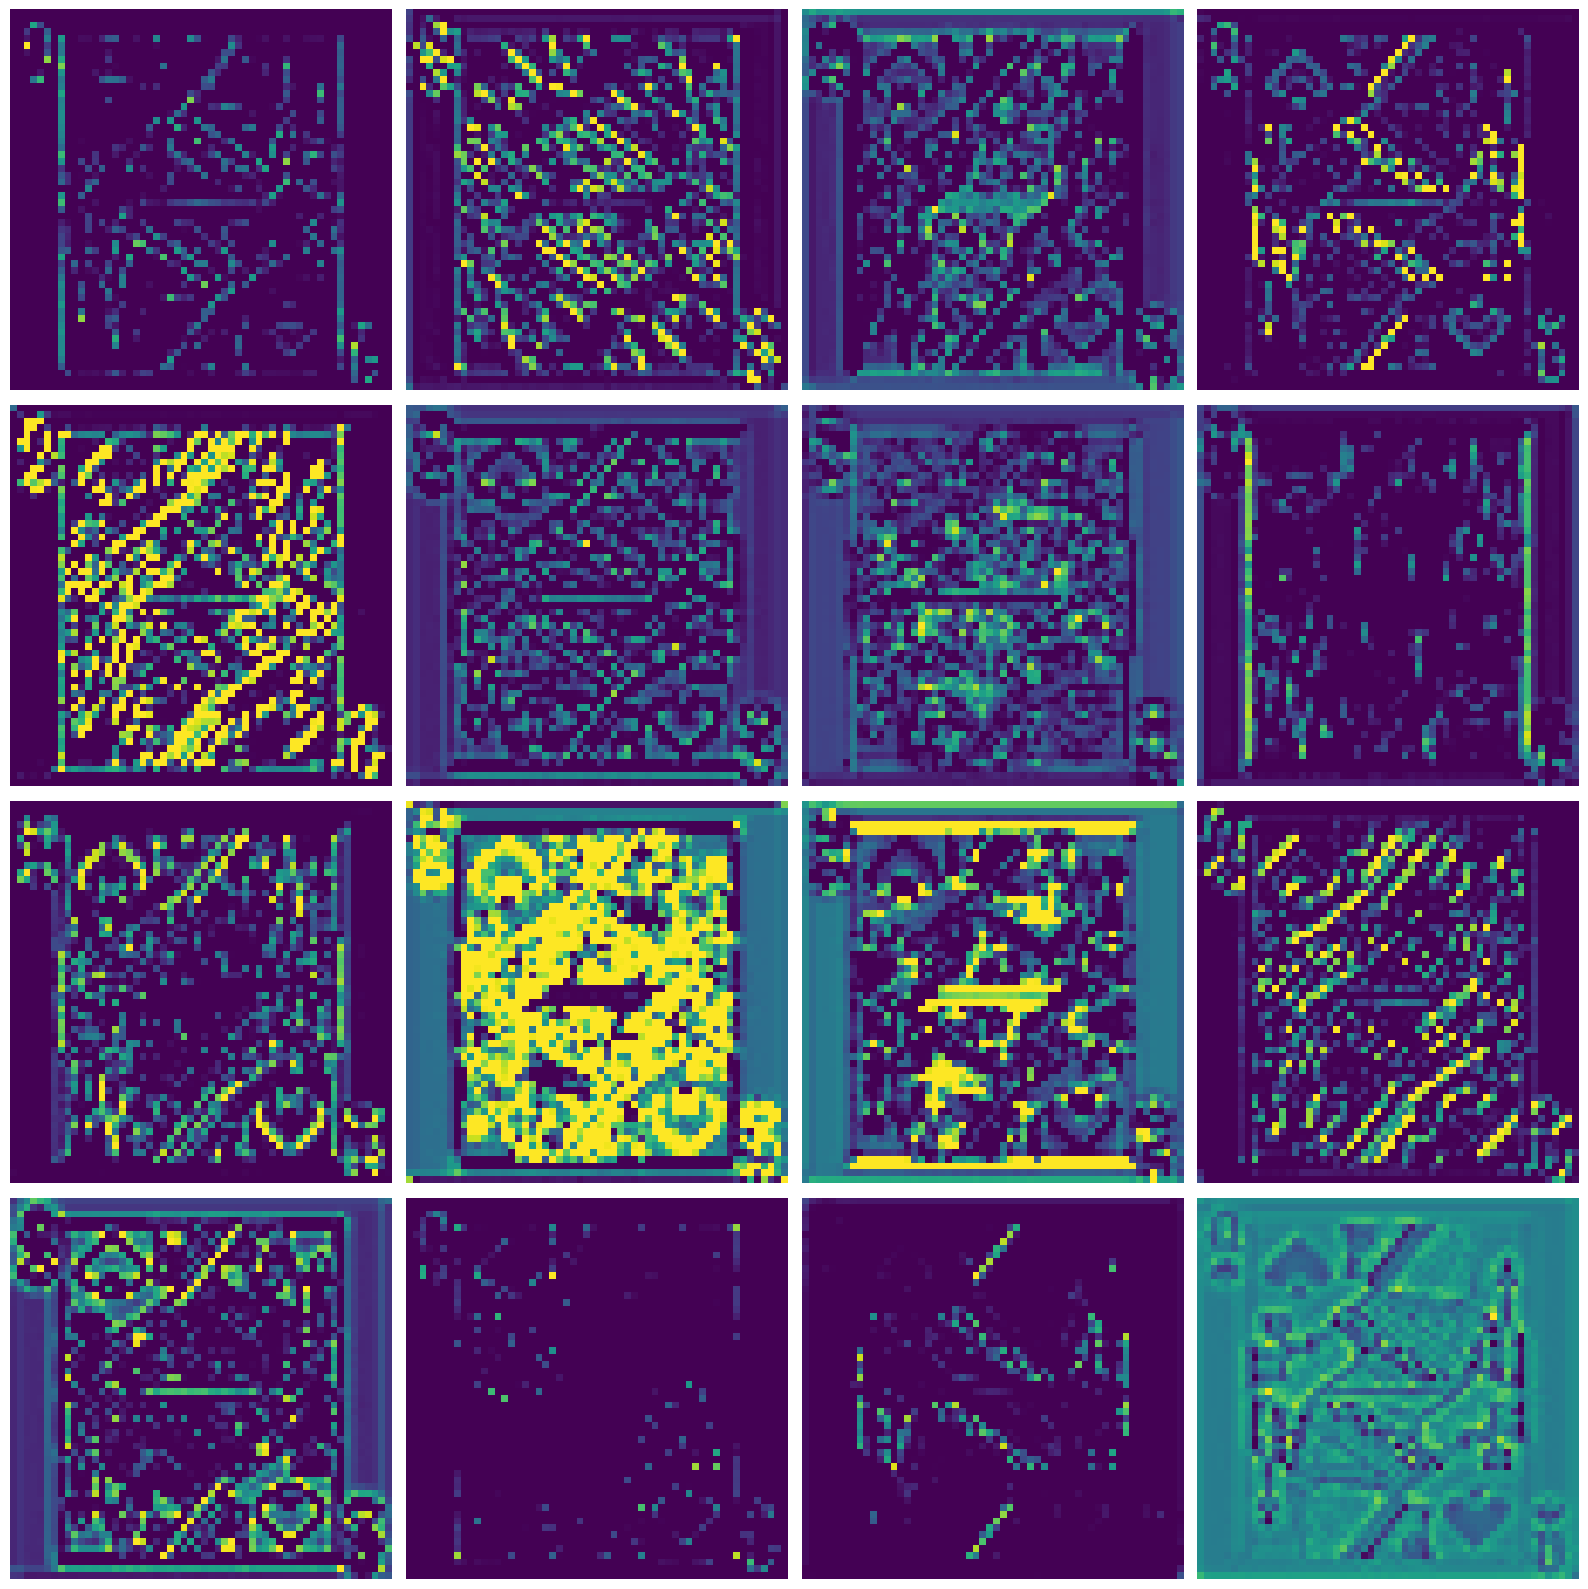


=== test/three of clubs/1.jpg @ layer block_3_expand_relu ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


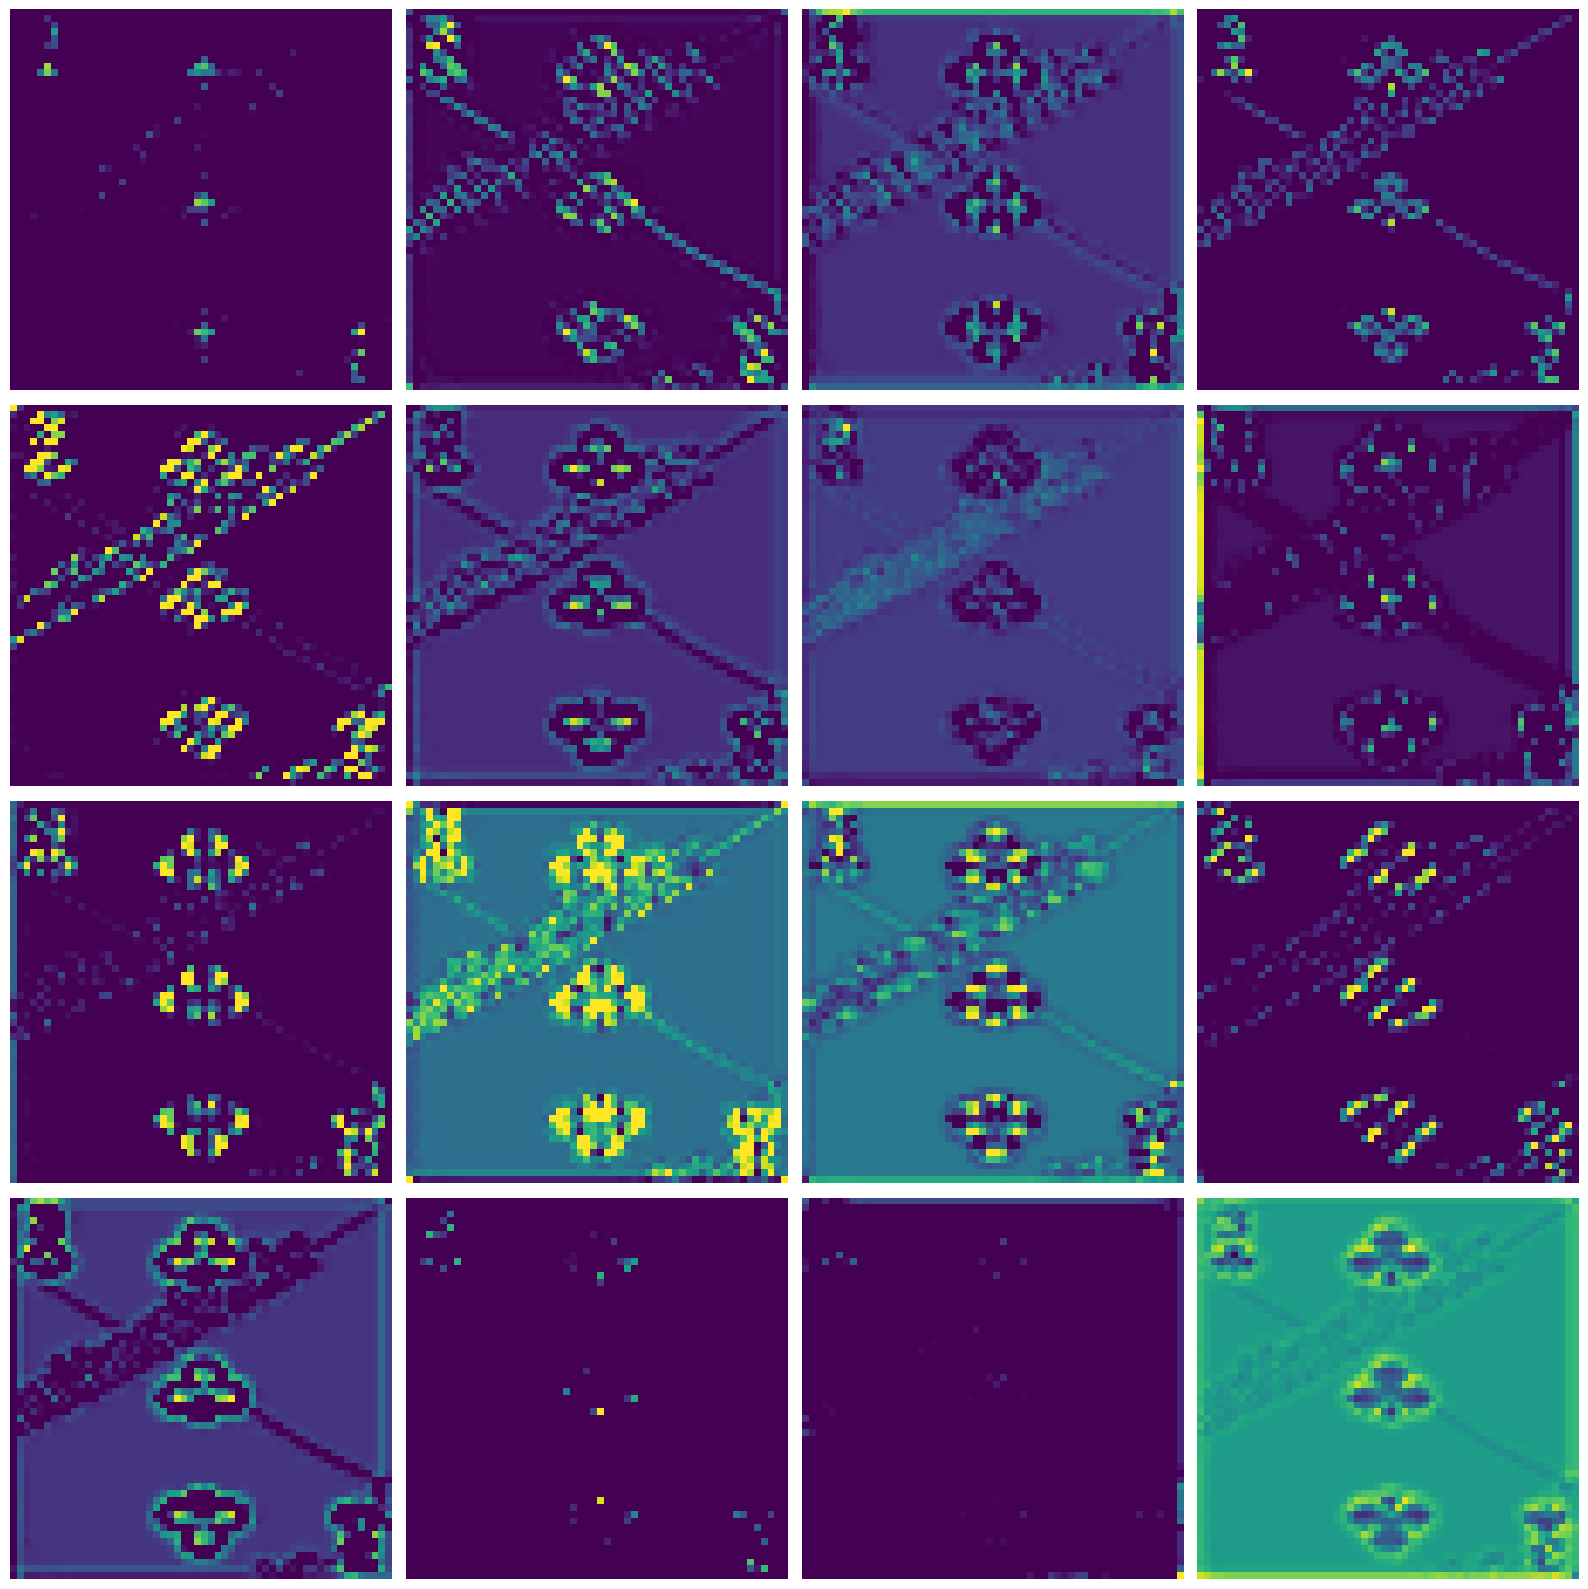


=== test/seven of diamonds/1.jpg @ layer block_3_expand_relu ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


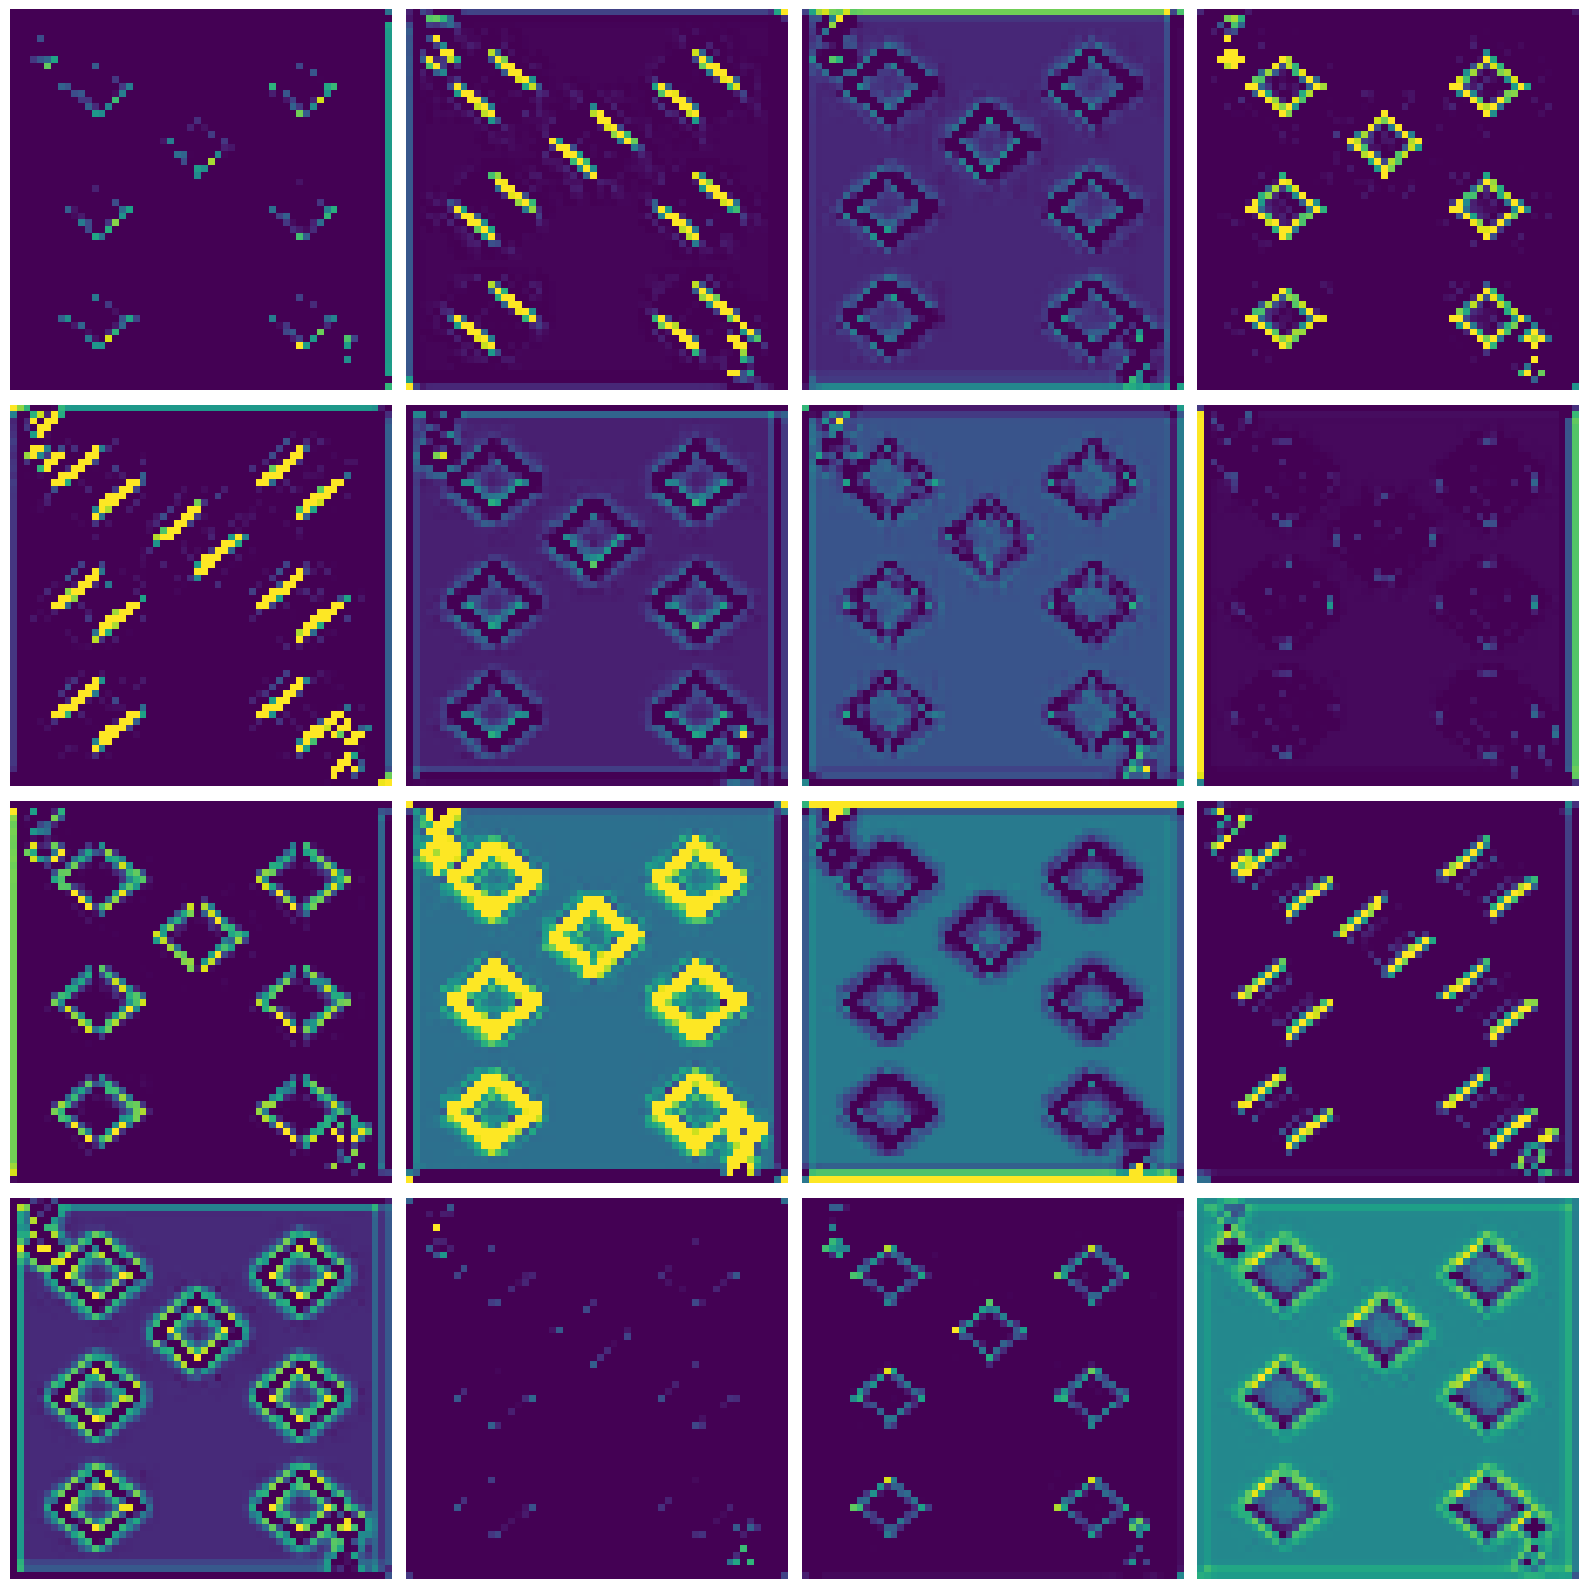

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model as KModel
import os

# your model’s input size
IMG_SIZE = model.input_shape[1:3]

# grab the nested MobileNetV2 trunk
base = model.get_layer('mobilenetv2_1.00_224')

def show_feature_maps(model, img_path, layer_name, n_maps=16):
    # 1) load & preprocess
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    x   = tf.keras.utils.img_to_array(img)[None, ...] / 255.0

    # 2) pick the right graph: top‐level if present, else the base
    if layer_name in {l.name for l in model.layers}:
        inp, out = model.input, model.get_layer(layer_name).output
    elif layer_name in {l.name for l in base.layers}:
        inp, out = base.input, base.get_layer(layer_name).output
    else:
        raise ValueError(f"No such layer '{layer_name}' in model or base.")

    # 3) build & run intermediate
    intermediate = KModel(inputs=inp, outputs=out)
    feats = intermediate.predict(x)[0]

    # 4) plot the first n_maps feature channels
    n = min(n_maps, feats.shape[-1])
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(feats[..., i], cmap='viridis')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Now call it with a real MobileNetV2 block_3 layer:
layer_to_inspect = "block_3_expand_relu"

examples = [
    "test/king of hearts/1.jpg",
    "test/queen of spades/1.jpg",
    "test/three of clubs/1.jpg",
    "test/seven of diamonds/1.jpg",
]

for ex in examples:
    img_path = os.path.join(IMG_BASE_DIR, ex)
    if not os.path.isfile(img_path):
        print(f"Missing: {img_path}")
        continue
    print(f"\n=== {ex} @ layer {layer_to_inspect} ===")
    show_feature_maps(model, img_path, layer_to_inspect)


## Training Performance and Metrics

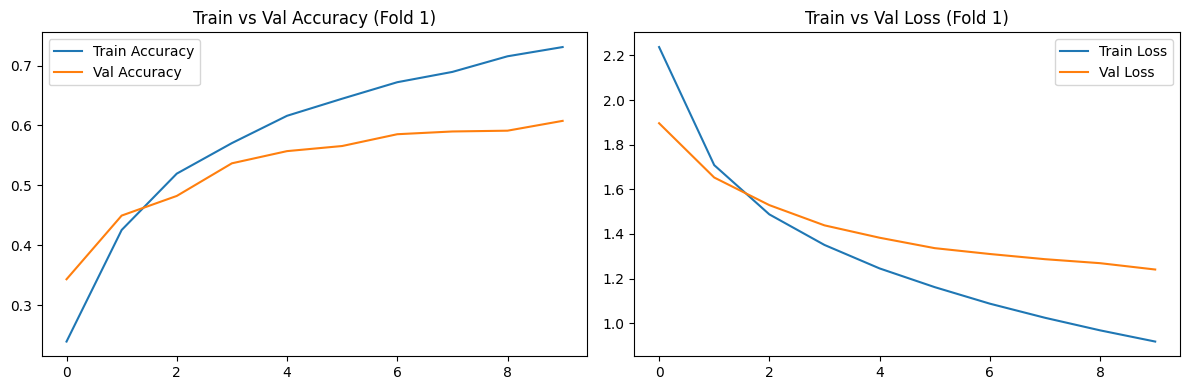

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_training_curves(history, fold):
    acc       = history.history['accuracy']
    val_acc   = history.history['val_accuracy']
    loss      = history.history['loss']
    val_loss  = history.history['val_loss']
    epochs    = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc,      label='Train Accuracy')
    plt.plot(epochs, val_acc,  label='Val Accuracy')
    plt.title(f'Train vs Val Accuracy (Fold {fold})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss,     label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'Train vs Val Loss (Fold {fold})')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history, fold=1)


**Figure 1. Training and Validation Accuracy (5-Fold CV).**  
The plot shows the epoch-wise training and validation accuracy curves averaged over 5 folds. The model consistently achieves ≥90 % validation accuracy by the final epochs, demonstrating strong generalization across unseen card classes.
Final figure shows
_Left:_ Epoch-wise training (blue) and validation (orange) accuracy curves for the first fold, showing the model improving steadily.  
_Right:_ Corresponding training (blue) and validation (orange) loss curves, which decrease in tandem without large divergence—indicating the model is learning effectively without overfitting on this fold.

**Figure 2. Training and Validation Loss (5-Fold CV).**  
This chart depicts the epoch-wise training and validation loss for each fold. The decreasing training loss combined with stable validation loss indicates that the network is learning meaningful representations without significant overfitting.

**Figure 3. Confusion Matrix on Test Set.**  
The confusion matrix summarizes per-class performance for all 14 card ranks. Diagonal entries close to 1.0 show high true positive rates, while off-diagonals remain minimal. Misclassifications, when they occur, tend to be between visually similar face or number cards.

**Figure 4. Feature Maps for “Ace of Spades” (block_6_expand_relu).**  
These sixteen feature maps from the `block_6_expand_relu` layer reveal how the network’s mid-level filters respond to the spade symbol and the large “A” glyph. High activations around the suit edges and central rank label indicate strong edge and shape detection.

**Figure 5. Feature Maps for “King of Hearts” (block_6_expand_relu).**  
Here the same layer’s filters highlight both the intricate facial patterns of the King illustration and the heart pips. Notice how some channels focus on color contrast along the crown and heart borders, illustrating the network’s sensitivity to fine details.

**Figure 6. Feature Maps for “3 of Clubs” (block_6_expand_relu).**  
These maps capture the three club symbols’ positions and orientations. The activations emphasize the repetitive circular shapes and stem geometry, showing that the model learns to detect multiple instances of identical elements.

**Figure 7. Feature Maps for “7 of Diamonds” (block_6_expand_relu).**  
In this set, filters activate strongly around the diamond pips, especially their angled edges and symmetry. The pattern of activations demonstrates the network’s ability to recognize repetitive geometric motifs across the card face.
